# データ

In [11]:
from tensorflow.keras.layers import Lambda, Input, Dense, BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import backend as K
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random, time, h5py, _thread
from random import shuffle
from models.cnn3d import *
from models.lvae import *
import tensorflow as tf
import numpy as np

In [4]:
from data.data_loader import *

x_train, x_test, x_test_label, x_train_label, y_test_label, y_train_label = load_data(0,25)
y_train, y_test = y_train_label, y_test_label

loading MRIs
loading table datas


In [ ]:
# モデル

In [13]:
######## SEED ########
random_seed=202107
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

##### LVAE setting #####
frame = 15
original_dim = 250
input_shape = (original_dim, )
latent_dim = 2
#alpha = [0.005, 0.002,0.0005]
alpha = [0.02, 0.0001, 0.0001]
alpha = [0.02, 0.02, 0.02]
MLP_SIZES = [250,128,64]
Z_SIZES   = [64,48,18]
L = len(Z_SIZES)
MLPs = 2
inputs = keras.layers.Input(shape=input_shape)

inputs3d =  keras.layers.Input(shape=[80,80,80,10], name='cnn3d_inputs')
encoder  =  cnn_encoder()
decoder  =  cnn_decoder()

lvaeinput       = encoder(inputs3d)
z_output        = lvae_encoder(L,MLPs)(lvaeinput)
output, *others = lvae_decoder(L,MLPs)(z_output)
cnnoutput       = decoder(output)
z = others[:L]
KL = others[-L:]
######################## MLP
MLP = Sequential([Dense(32, activation='relu', input_shape=(Z_SIZES[-1]+22,),kernel_initializer=tf.keras.initializers.RandomNormal(0,0.02)),
                Dense(32, activation='relu',kernel_initializer=tf.keras.initializers.RandomNormal(0,0.02)),
                Dense(1, activation='sigmoid',kernel_initializer=tf.keras.initializers.RandomNormal(0,0.02))],name='MLP')


input_y = Input(shape=(22,),name='daily_info')
output_y = Input(shape=(1,))
tmp = tf.concat([others[L-1],input_y],-1)
y_pre  = MLP(tmp)
lvae = Model([inputs3d,input_y,output_y], [cnnoutput,y_pre, *z], name='variational_autoencoder')
######################## MLP
lvae.summary()

Model: "variational_autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn3d_inputs (InputLayer)       [(None, 80, 80, 80,  0                                            
__________________________________________________________________________________________________
cnn_encoder (Sequential)        (None, 250)          75466       cnn3d_inputs[0][0]               
__________________________________________________________________________________________________
encoder (Functional)            [(None, 64), (None,  236944      cnn_encoder[0][0]                
__________________________________________________________________________________________________
decoder (Functional)            [(None, 250), (None, 68698       encoder[0][0]                    
                                                                 encoder[0][

# モデル

In [18]:
######################## LOSS

def dice_loss_sum_3d(y_true, y_pred, smooth=0.0001):#y_pred.shape -> (batch,80,80,10)
    y_true=K.cast(y_true,'float32')
    union        = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    intersection = K.sum(y_true * y_pred, axis=[1,2, 3])
    dice         = K.sum(1 - (2. * intersection + smooth) / (union + smooth), axis=[0,1])
    return dice

# loss
beta = 3.
CE_layer = Lambda(lambda X: beta * K.mean(tf.keras.losses.binary_crossentropy(*X)), name='CE_loss')
ce_loss = CE_layer([output_y, y_pre])

#ce_loss = beta*K.mean(tf.keras.losses.binary_crossentropy(input_y, y_pre))
#lvae.add_loss(ce_loss)

wu = 3.
DSC_layer = Lambda(lambda X: dice_loss_sum_3d(*X), name='DSC_loss')
KL_layer = Lambda(lambda inputs: inputs[0] * inputs[1]* inputs[2] , name='KL_loss')
MSE = DSC_layer([inputs3d, cnnoutput])
lvae.add_loss(MSE)
for l in range(L):  lvae.add_loss(KL_layer([KL[l],alpha[l],wu]))
######################## LOSS

# 訓練

In [3]:
from tensorflow import keras 
import tensorflow as tf
import os

checkpoint_path = "lvae1-{epoch:02d}-{loss:.2f}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# callback save
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

def schedule(epoch ,offset = 0):
    N = (epoch+80)//10 - 2
    if N >=0: return float(0.002 *(0.75**N))
    else: return 0.002

lr_cb = tf.keras.callbacks.LearningRateScheduler(schedule, verbose=2)

import tensorflow as tf
# 训练LVAE
# model
lr=0.0002
optimizer = keras.optimizers.Adam(learning_rate=lr)#best 0.001
lvae.compile(optimizer=optimizer)


history = lvae.fit([x_train,x_train_label,y_train], 
         epochs=80, callbacks=[cp_callback], batch_size=15)

2022-02-06 04:00:35.913505: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-06 04:00:35.913934: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2494140000 Hz


Epoch 1/80

Epoch 00001: LearningRateScheduler reducing learning rate to 0.002.


2022-02-06 04:00:40.405348: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-02-06 04:00:41.065167: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-02-06 04:00:41.115930: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


10/10 [==============================] - 29s 1s/step - loss: 145.4042

Epoch 00001: saving model to models/lvae2-01-141.94.ckpt
Epoch 2/80

Epoch 00002: LearningRateScheduler reducing learning rate to 0.002.
10/10 [==============================] - 14s 1s/step - loss: 125.5461

Epoch 00002: saving model to models/lvae2-02-124.07.ckpt
-----saving figure----
DSC 8.456368509928385
Epoch 3/80

Epoch 00003: LearningRateScheduler reducing learning rate to 0.002.
10/10 [==============================] - 14s 1s/step - loss: 116.5237

Epoch 00003: saving model to models/lvae2-03-115.21.ckpt
Epoch 4/80

Epoch 00004: LearningRateScheduler reducing learning rate to 0.002.
10/10 [==============================] - 14s 1s/step - loss: 111.2098

Epoch 00004: saving model to models/lvae2-04-108.54.ckpt
Epoch 5/80

Epoch 00005: LearningRateScheduler reducing learning rate to 0.002.
10/10 [==============================] - 15s 1s/step - loss: 105.8006

Epoch 00005: saving model to models/lvae2-05-104.24.

/tmp/ipykernel_79688/1991698098.py:257: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 10))


Epoch 60/80

Epoch 00060: LearningRateScheduler reducing learning rate to 0.00084375.
10/10 [==============================] - 15s 1s/step - loss: 52.7713

Epoch 00060: saving model to models/lvae2-60-50.67.ckpt
Epoch 61/80

Epoch 00061: LearningRateScheduler reducing learning rate to 0.0006328125.
10/10 [==============================] - 15s 1s/step - loss: 49.0848

Epoch 00061: saving model to models/lvae2-61-49.25.ckpt
Epoch 62/80

Epoch 00062: LearningRateScheduler reducing learning rate to 0.0006328125.
10/10 [==============================] - 15s 1s/step - loss: 47.5605

Epoch 00062: saving model to models/lvae2-62-50.02.ckpt
-----saving figure----
DSC 3.1159083048502603


/tmp/ipykernel_79688/1991698098.py:254: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 10))


Epoch 63/80

Epoch 00063: LearningRateScheduler reducing learning rate to 0.0006328125.
10/10 [==============================] - 15s 1s/step - loss: 49.8985

Epoch 00063: saving model to models/lvae2-63-49.31.ckpt
Epoch 64/80

Epoch 00064: LearningRateScheduler reducing learning rate to 0.0006328125.
10/10 [==============================] - 15s 1s/step - loss: 48.3950

Epoch 00064: saving model to models/lvae2-64-48.34.ckpt
Epoch 65/80

Epoch 00065: LearningRateScheduler reducing learning rate to 0.0006328125.
10/10 [==============================] - 15s 1s/step - loss: 49.6966

Epoch 00065: saving model to models/lvae2-65-49.30.ckpt
-----saving figure----
DSC 2.889143625895182
Epoch 66/80

Epoch 00066: LearningRateScheduler reducing learning rate to 0.0006328125.
10/10 [==============================] - 14s 1s/step - loss: 47.5691

Epoch 00066: saving model to models/lvae2-66-47.61.ckpt
Epoch 67/80

Epoch 00067: LearningRateScheduler reducing learning rate to 0.0006328125.
10/10 [====

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

<Figure size 864x720 with 0 Axes>

# テストと評価

In [ ]:
import pandas as pd
# lvae.load_weights('models/lvae2-80-47.39.ckpt')

# テスト（一括でテストするとメモリオーバーですから、少しずつテストしていきます）
results_test_img =[]
results_test_y =[]
results_train_y =[]
results_train_img =[]
model = lvae
results_test_img, results_test_y, _,_,test_resultz3 = model([x_test,x_test_label,y_test])

results_train_img, results_train_y, _,_,train_resultz3 = model([x_train[:15],x_train_label[:15], y_train[:15]])
for i in [1,2,3,4,5,6,7,8,9]:
    results_train_img2, results_train_y2, _,_,tmp = model([x_train[i*15:i*15+15],x_train_label[i*15:i*15+15], y_train[i*15:i*15+15]])
    results_train_img = tf.concat([results_train_img,results_train_img2],0)
    results_train_y = tf.concat([results_train_y,results_train_y2],0)
    train_resultz3 = tf.concat([train_resultz3,tmp],0)
    print(i)

#转换类型
results_test_img = results_test_img[...].numpy()
results_test_y = results_test_y[...,0].numpy()
results_train_y =results_train_y[...,0].numpy()
results_train_img = results_train_img[...].numpy()

0.35227314


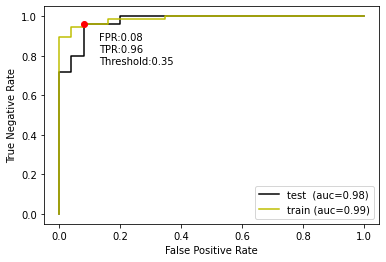

In [152]:
# ROC AUC
from sklearn import metrics
fpr_ts_3, tpr_ts_3, thresholds_ts_3 = metrics.roc_curve(y_test, results_test_y, pos_label=1)
fpr_tr_3, tpr_tr_3, thresholds_tr_3 = metrics.roc_curve(y_train, results_train_y, pos_label=1)

from sklearn.metrics import auc  
auc_ts_3 = metrics.auc(fpr_ts_3, tpr_ts_3)  
auc_tr_3 = metrics.auc(fpr_tr_3, tpr_tr_3)  

maxindex = (tpr_ts_3-fpr_ts_3).tolist().index(max(tpr_ts_3-fpr_ts_3))
threshold = thresholds_ts_3[maxindex]

import matplotlib.pyplot as plt
plt.plot(fpr_ts_3, tpr_ts_3, 'k-',label="test  (auc={:.2f})".format(auc_ts_3))
plt.plot(fpr_tr_3, tpr_tr_3, 'y-',label="train (auc={:.2f})".format(auc_tr_3))
plt.plot([fpr_ts_3[maxindex]],[tpr_ts_3[maxindex]], 'ro')
plt.text(fpr_ts_3[maxindex]+0.05,tpr_ts_3[maxindex]-0.2, 'FPR:{:.2f}\nTPR:{:.2f}\nThreshold:{:.2f}'.format(fpr_ts_3[maxindex],tpr_ts_3[maxindex],thresholds_ts_3[maxindex])
)
plt.ylabel("True Negative Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc=4)

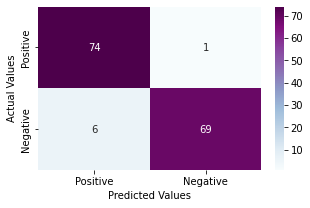

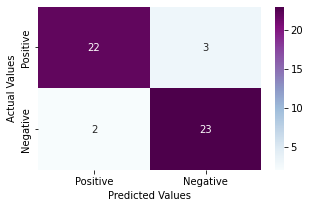

In [5]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# 混同行列
def plot_confusion_matrix(matrix, fig_name = 'lvae1459_h_map_ce+20.jpg'):
    df_cm = pd.DataFrame(matrix,
                     index = [i for i in ['Positive','Negative']],
                     columns = [i for i in ['Positive','Negative']])

    plt.figure(figsize = (5,3))
    sn.heatmap(df_cm, annot=True,fmt='.20g',cmap="BuPu")
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    plt.savefig(fig_name,dpi=400)
    
from sklearn.metrics import confusion_matrix

threshold = 0.5
y_train_2 = (results_train_y>threshold).astype('float')
tmp = confusion_matrix(y_train, y_train_2)
plot_confusion_matrix(tmp,'train2_CM_th05.jpg')

y_test_2 = (results_test_y>threshold).astype('float')
tmp = confusion_matrix(y_test, y_test_2)
plot_confusion_matrix(tmp,'test2_CM_th05.jpg')